In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qibo.gates import M, X, RY, CZ, I, H
from qibo.models import Circuit
from qiboconnection.api import API
import matplotlib.pyplot as plt

from qiboconnection.connection import ConnectionConfiguration

from benchmarks.utils.qst_qpt_helper_functions import process_returned_dataformat
from time import sleep

from itertools import product
from scipy.stats import multivariate_normal
api = API(ConnectionConfiguration(username="vsanchez", api_key="ea712370-7516-4cbf-91a6-72a82e39ba02"))
from scipy import stats

api.select_device_id(9)

### Experiment parameters

In [2]:
CONTROL_QUBIT = 2
TARGET_QUBIT = 0
THETA_VALUES = np.linspace(-np.pi, np.pi, num=20)
BELL_STATE = "psi_minus" # phi_plus, phi_minus, psi_plus, psi_minus

NUM_SHOTS = 8000

LOAD_RESULTS = True
mfidelity_qc = 0.88 # measurement fidelity control qubit
mfidelity_qt = 0.84 # measurement fidelity target qubit

### Circuits definitions

In [3]:
def get_chsh_circuits(bell_state, control_qubit, target_qubit, theta):
    assert bell_state in (
        "phi_plus",
        "phi_minus",
        "psi_plus",
        "psi_minus",
    ), "bell_state should be phi_plus, phi_minus, psi_plus, psi_minus"
    nqubits = max(control_qubit, target_qubit) + 1

    circuits = []
    for gate_a, gate_b in product([I, H], repeat=2):
        circuit = Circuit(nqubits)

        if bell_state == "phi_plus" or bell_state == "psi_minus":
            G1 = RY(control_qubit, theta=-np.pi / 2)
        else:
            G1 = RY(control_qubit, theta=np.pi / 2)
        if bell_state == "phi_plus" or bell_state == "phi_minus":
            G2_prime = RY(target_qubit, theta=-np.pi / 2)
        else:
            G2_prime = RY(target_qubit, theta=np.pi / 2)
        ## build bell state
        circuit.add(G1)
        circuit.add(RY(target_qubit, theta=np.pi / 2))
        circuit.add(CZ(control_qubit, target_qubit))
        circuit.add(G2_prime)

        ## decoder part
        circuit.add(RY(control_qubit, theta=theta))
        circuit.add(gate_a(control_qubit))
        circuit.add(gate_b(target_qubit))
        circuit.add(M(control_qubit, target_qubit))

        circuits.append(circuit)

    return circuits


def SPAM_circuits(control_qubit, target_qubit):
    """Circuits to get the SPAM matrix in order to perform measurement correction."""
    calibration_circuits = []
    for gate_a, gate_b in product([I, X], repeat=2):
        calibration_circuit = Circuit(5)
        calibration_circuit.add(gate_a(control_qubit))
        calibration_circuit.add(gate_b(target_qubit))
        calibration_circuit.add(M(control_qubit, target_qubit))

        calibration_circuits.append(calibration_circuit)
    return calibration_circuits


def compute_witnesses(chsh_results, measurement_calibration_weights, BELL_STATE, raw=False):
    """Returns arrays of computed witness values.

    Args:
        chsh_results (array): matrix containing the probabilities the chsh circuits. It must be
                        of dimensions len(theta_values) x 4 (decoder circuits) x 4 (probabilities)
        measurement_calibration_weights (array): measurement calibration matrix.
        BELL_STATE (string): can be "phi_plus", "phi_minus", "psi_plus" or "psi_minus". It needs
                            to be specified because the witness isn't the same for all 4 Bell states.
        raw (bool): whether or not calculate the witnesses from the raw data instead of applying the
                    measurement corrections. Defaults to False.
    Returns:
        witness1 (array): array length len(theta_values) containing the first witness
        witness2 (array): array length len(theta_values) containing the second witness
    """
    len_theta_values = np.shape(chsh_results)[0]
    witness1 = np.zeros(len_theta_values)
    witness2 = np.zeros(len_theta_values)

    if BELL_STATE in ["phi_plus", "psi_minus"]:
        signs1 = np.array([1, 1, -1, 1])
        signs2 = np.array([1, -1, 1, 1])
    else:
        signs1 = np.array([-1, 1, 1, 1])
        signs2 = np.array([1, 1, 1, -1])

    for i, chsh_result in enumerate(chsh_results):
        if raw is not True:
            # apply measurement calibration
            chsh_result = measurement_calibration_weights @ chsh_result.T
            # calculate expectation values from probabilities
            expectations = np.array([1, -1, -1, 1]).T @ chsh_result

        else:
            # calculate expectation values from probabilities
            expectations = chsh_result @ np.array([1, -1, -1, 1])
        # compute witnesses
        witness1[i] = signs1.T @ expectations
        witness2[i] = signs2.T @ expectations
    return witness1, witness2

### Build circuits for CHSH and measurement correction

In [4]:
all_circuits_chsh = []
for theta in THETA_VALUES:
    circuits_th = get_chsh_circuits(BELL_STATE, CONTROL_QUBIT, TARGET_QUBIT, theta)
    all_circuits_chsh.extend(circuits_th)

all_circuits = SPAM_circuits(CONTROL_QUBIT, TARGET_QUBIT)

all_circuits.extend(all_circuits_chsh)

### Run circuits

In [5]:
result_id = 8695

if LOAD_RESULTS is False:
    result_id = api.execute(all_circuits, nshots=NUM_SHOTS)[0]

### Wait until execution has finished

In [6]:
results = None
while results is None:
    results = api.get_result(result_id)
    sleep(30)
results

Your job with id 8695 is completed.


[{'probabilities': {'00': 0.7305, '01': 0.1315, '10': 0.1175, '11': 0.0205}},
 {'probabilities': {'00': 0.158, '01': 0.717, '10': 0.0315, '11': 0.0935}},
 {'probabilities': {'00': 0.1545, '01': 0.027, '10': 0.6985, '11': 0.12}},
 {'probabilities': {'00': 0.0265, '01': 0.158, '10': 0.131, '11': 0.6845}},
 {'probabilities': {'00': 0.429, '01': 0.088, '10': 0.0855, '11': 0.3975}},
 {'probabilities': {'00': 0.26, '01': 0.2575, '10': 0.2405, '11': 0.242}},
 {'probabilities': {'00': 0.27, '01': 0.263, '10': 0.254, '11': 0.213}},
 {'probabilities': {'00': 0.392, '01': 0.1325, '10': 0.114, '11': 0.3615}},
 {'probabilities': {'00': 0.4215, '01': 0.0925, '10': 0.099, '11': 0.387}},
 {'probabilities': {'00': 0.2315, '01': 0.296, '10': 0.281, '11': 0.1915}},
 {'probabilities': {'00': 0.3145, '01': 0.2135, '10': 0.2085, '11': 0.2635}},
 {'probabilities': {'00': 0.3725, '01': 0.1255, '10': 0.123, '11': 0.379}},
 {'probabilities': {'00': 0.3935, '01': 0.1275, '10': 0.13, '11': 0.349}},
 {'probabiliti

### Process real data

In [7]:
## retrieve data
results = api.get_result(result_id)
data_probabilities = process_returned_dataformat(results, nqubits=2)

## measurement calibration data processing
spam_data_probabilities = data_probabilities[:4]
measurement_calibration_weights = np.linalg.inv(spam_data_probabilities)

## chsh circuits data processing
chsh_data_probabilities = data_probabilities[4:]
chsh_data_probabilities_theta = chsh_data_probabilities.reshape(len(THETA_VALUES), 4, 4)


## compute witness
w1_raw, w2_raw = compute_witnesses(chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=True)
w1_corrected, w2_corrected = compute_witnesses(
    chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=False
)

Your job with id 8695 is completed.


### Run simulation, get ideal witnesses

In [8]:
circ_list = SPAM_circuits(0, 1)
ideal_results_spam = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_spam[i] += c.execute().probabilities()
ideal_measurement_calibration_weights = np.linalg.inv(ideal_results_spam)

circ_list = list(np.copy(all_circuits_chsh))
ideal_results_chsh = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_chsh[i] += c.execute().probabilities()

ideal_results_chsh_theta = ideal_results_chsh.reshape(len(THETA_VALUES), 4, 4)

w1_ideal, w2_ideal = compute_witnesses(
    ideal_results_chsh_theta, ideal_measurement_calibration_weights, BELL_STATE, raw=False
)

[Qibo 0.1.12.dev0|INFO|2024-03-01 00:59:47]: Using numpy backend on /CPU:0


### Get error bars

In [9]:
def return_mock_results(data_probabilities, ea=1, eb=1):
    # returns simulated results using distribution from experimental results' probabilities
    mock_results = np.empty(shape=data_probabilities.shape)
    # measurement_calibration_weights = np.linalg.inv(data_probabilities[:4])

    e_m = np.array([[ea*eb, ea*(1-eb), eb*(1-ea), (1-ea)*(1-eb)],
                    [ea*(1-eb), ea*eb, (1-ea)*(1-eb), eb*(1-ea)],
                    [eb*(1-ea), (1-ea)*(1-eb), ea*eb, ea*(1-eb)],
                    [(1-ea)*(1-eb), ea*(1-eb), eb*(1-ea), ea*eb]])
    
    for i, _ in enumerate(mock_results):    
        mock_results[i] = (stats.multinomial.rvs(NUM_SHOTS, data_probabilities[i]) / NUM_SHOTS) @ np.linalg.inv(e_m)

    measurement_calibration_weights = np.linalg.inv(data_probabilities[:4])
    mock_results = mock_results[4:]


    return list((compute_witnesses(mock_results.reshape(-1, 4, 4), measurement_calibration_weights, BELL_STATE, raw=False) +
            compute_witnesses(mock_results.reshape(-1, 4, 4), measurement_calibration_weights, BELL_STATE, raw=True)))
    
def get_err_bars(mock_results):
    data_hist = np.stack(mock_results)
    err_bars = np.empty(len(data_hist.T))
    for i, hist in enumerate(data_hist.T):
        _ , var = stats.norm.fit(hist)
        err_bars[i] =np.sqrt(var)
    return err_bars

# generate n copies of random results
err_w1, err_w2, err_w1_unc, err_w2_unc  = [get_err_bars(mock_results) for mock_results in zip(*[return_mock_results(data_probabilities, ea=mfidelity_qc, eb=mfidelity_qt) for _ in range(800)])]

In [10]:
data_a = np.array([return_mock_results(data_probabilities) for _ in range(1000)])
data_b =np.array([return_mock_results(data_probabilities, ea=mfidelity_qc, eb=mfidelity_qc) for _ in range(1000)])

err_sys_w1 = []
for data_spam, data_fid in zip(data_a[:,0,:].T, data_b[:,2,:].T):
    mean_spam, var_spam = stats.norm.fit(data_spam)
    mean_fid, var_fid = stats.norm.fit(data_fid)
    err_sys_w1.append(mean_fid - mean_spam)
    
err_sys_w2 = []
for data_spam, data_fid in zip(data_a[:,1,:].T, data_b[:,3,:].T):
    mean_spam, var_spam = stats.norm.fit(data_spam)
    mean_fid, var_fid = stats.norm.fit(data_fid)
    err_sys_w2.append(mean_fid - mean_spam)
    
err_total_w1 = np.array([[err1, np.sqrt(err1**2+err2**2)] if err2 > 0 else [np.sqrt(err1**2 + err2**2), err1] for err1, err2 in zip(err_w1, err_sys_w1)])
err_total_w2 = np.array([[err1, np.sqrt(err1**2+err2**2)] if err2 > 0 else [np.sqrt(err1**2 + err2**2), err1] for err1, err2 in zip(err_w2, err_sys_w2)])

### Plot results

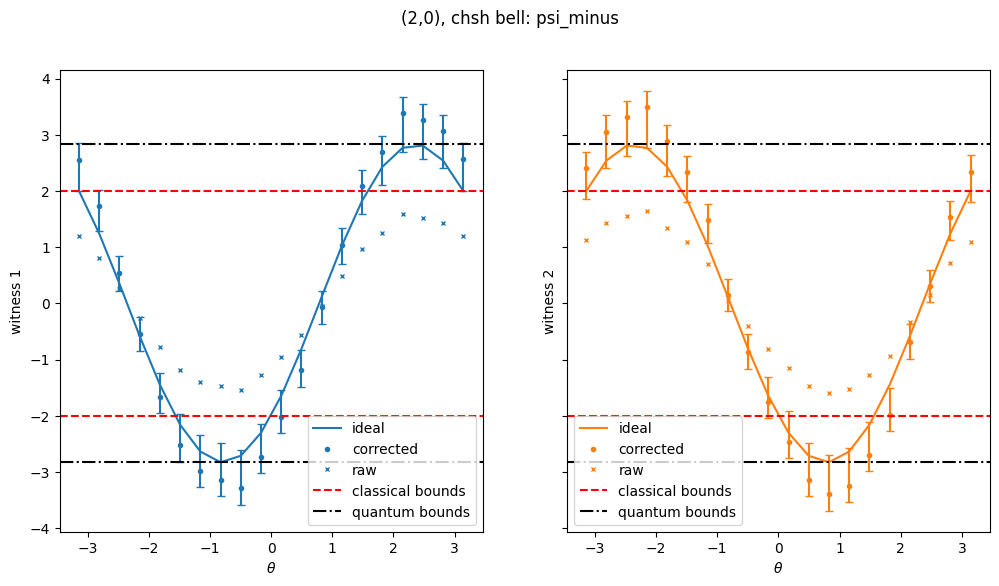

In [12]:
fname = f"chsh_{CONTROL_QUBIT}_{TARGET_QUBIT}_{BELL_STATE}_nshots{NUM_SHOTS}_jobid{result_id}.png"
savefig = False

fig, (ax0, ax1) = plt.subplots(1,2, sharey=True, figsize=(12, 6))

ax0.plot(THETA_VALUES, w1_ideal, c="C0", label="ideal")
ax0.plot(THETA_VALUES, w1_corrected, ".", c="C0", label="corrected")
ax0.plot(THETA_VALUES, w1_raw, "x", ms=3, c="C0", label="raw")
ax0.errorbar(THETA_VALUES, w1_corrected, err_total_w1.T, capsize=3, c="C0", ls="none")
ax0.set_ylabel("witness 1")


ax1.plot(THETA_VALUES, w2_ideal,c="C1", label="ideal")
ax1.plot(THETA_VALUES, w2_corrected, ".", c="C1", label="corrected")
ax1.plot(THETA_VALUES, w2_raw, "x", ms=3, c="C1", label="raw")
ax1.errorbar(THETA_VALUES, w2_corrected, err_total_w2.T, capsize=3, c="C1", ls="none")
ax1.set_ylabel("witness 2")

for ax in ax0, ax1:
    ax.axhline(2, color="red", linestyle="--", label="classical bounds")
    ax.axhline(-2, color="red", linestyle="--")
    ax.axhline(2 * np.sqrt(2), color="k", linestyle="-.", label="quantum bounds")
    ax.axhline(-2 * np.sqrt(2), color="k", linestyle="-.")
    ax.set_xlabel("$\\theta$")
    ax.legend()

fig.suptitle(f"({CONTROL_QUBIT},{TARGET_QUBIT}), chsh bell: {BELL_STATE}")
if savefig:
    fig.savefig(fname, bbox_inches="tight")